# Klasifikasi Gambar

## Import Library

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image

import zipfile
import os
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Load Dataset

In [3]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# Download dataset
!kaggle datasets download --force ilhamhasib/vehicle-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/ilhamhasib/vehicle-classification-dataset
License(s): CC-BY-SA-4.0
100% 4.37G/4.38G [00:55<00:00, 96.8MB/s]
100% 4.38G/4.38G [00:55<00:00, 84.7MB/s]


In [5]:
# Ekstrak dataset
zip_path = 'vehicle-classification-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

## Mengecek Resolusi Gambar

In [15]:
# Path to the train directory
train_dir = "/content/Car-Classification-Data-with-Labels-iHasib/Train"

# Dictionary to store image resolutions
image_resolutions = {}

# Counter to limit the number of images processed
image_count = 0
max_images = 5

# Iterate through each subfolder and image file
for subdir, _, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                image_resolutions[file_path] = img.size
                image_count += 1
                if image_count >= max_images:
                    break

# Print the resolutions
for path, resolution in image_resolutions.items():
    print(f'{path}: {resolution}')

/content/Car-Classification-Data-with-Labels-iHasib/Train/5730.jpg: (725, 400)
/content/Car-Classification-Data-with-Labels-iHasib/Train/3227.jpg: (2048, 1366)
/content/Car-Classification-Data-with-Labels-iHasib/Train/5447.jpg: (1364, 1907)
/content/Car-Classification-Data-with-Labels-iHasib/Train/3241.jpg: (2048, 1536)
/content/Car-Classification-Data-with-Labels-iHasib/Train/4134.jpg: (630, 445)


## Labeling Data

In [16]:
# Load the labels
labels_df = pd.read_csv('Car-Classification-Data-with-Labels-iHasib/type-labels.csv')
labels_df.head(10)

,ID,Type
0,0,Bike
1,1,Bike
2,2,Bike
3,3,Bike
4,4,Bike
5,5,Bike
6,6,Bike
7,7,Bike
8,8,Bike
9,9,Bike


In [17]:
# Create directories for each label
for label in labels_df['Type'].unique():
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)

# Move images to corresponding label directories
for index, row in labels_df.iterrows():
    img_id = row['ID']
    label = row['Type']
    src_path = os.path.join(train_dir, f'{img_id}.jpg')
    dst_path = os.path.join(train_dir, label, f'{img_id}.jpg')
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

## Augmentasi Gambar

In [18]:
# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5187 images belonging to 10 classes.
Found 1293 images belonging to 10 classes.


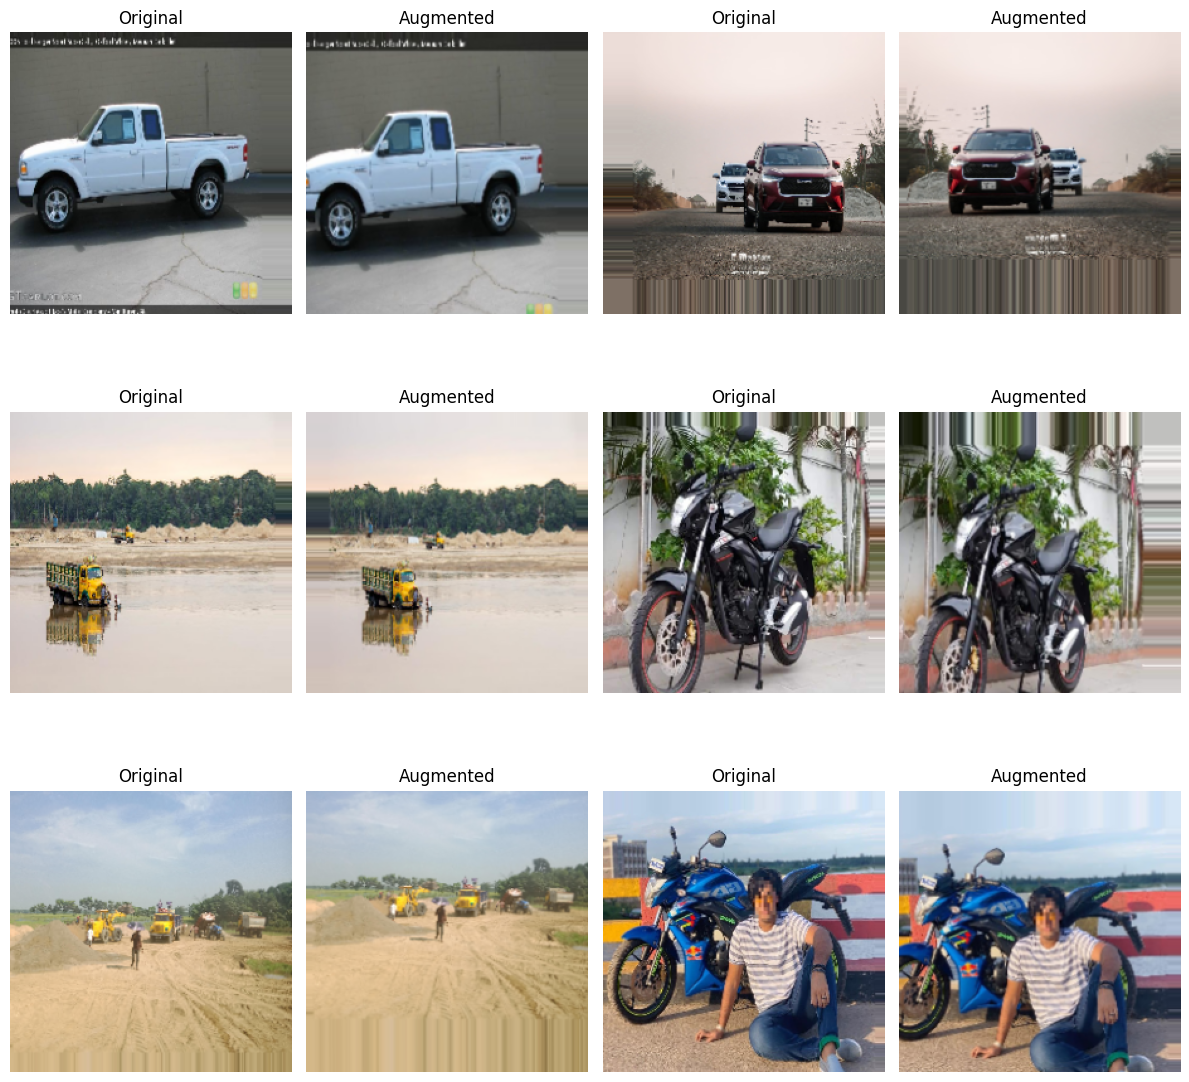

In [19]:
# Ambil batch gambar dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    # Augmentasi gambar
    augmented_image = train_datagen.random_transform(images[i])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define the Model

In [29]:
tf.keras.backend.clear_session

<function keras.src.backend.common.global_state.clear_session(free_memory=True)>

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Reshape, Input
from tensorflow.keras.models import Sequential
import tf_keras
import tensorflow_hub as hub

In [22]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [23]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
from keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def __init__(self, patience=3):
        super(StopTrainingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("\n Akurasi 95% tercapai. Proses train dihentikan...\n")
            self.model.stop_training = True
            return

        current_val_loss = logs.get("val_loss")
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n Tidak ada penurunan nilai loss validasi setelah {self.patience} epochs. Proses train dihentikan...\n")
                self.model.stop_training = True

In [25]:
# Melatih model
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
history = model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID,
    epochs=20,
    callbacks = StopTrainingCallback()
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.1751 - loss: 2.9581 - val_accuracy: 0.2688 - val_loss: 2.1206
Epoch 2/20
  1/162 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.3125 - loss: 2.0754

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


162/162 ━━━━━━━━━━━━━━━━━━━━ 73s 455ms/step - accuracy: 0.3125 - loss: 2.0754 - val_accuracy: 0.2523 - val_loss: 2.1262
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.2792 - loss: 2.0174 - val_accuracy: 0.3039 - val_loss: 1.9595
Epoch 4/20
  1/162 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.4375 - loss: 1.6127

KeyboardInterrupt: 

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new classification layers
x = base_model.output
x = Conv2D(32, (3, 3), activation='relu')(x) # Conv2D layer
x = MaxPooling2D((2, 2))(x) # MaxPooling2D layer
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks = StopTrainingCallback())

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.5694 - loss: 1.2743 - val_accuracy: 0.6713 - val_loss: 0.8977
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.7962 - loss: 0.5880 - val_accuracy: 0.7162 - val_loss: 0.9098
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.8326 - loss: 0.4740 - val_accuracy: 0.7208 - val_loss: 0.7879
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.8440 - loss: 0.4428 - val_accuracy: 0.7301 - val_loss: 0.9404
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.8611 - loss: 0.3971 - val_accuracy: 0.7254 - val_loss: 0.8574
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8966 - loss: 0.2900 - val_accuracy: 0.7711 - val_loss: 0.7329
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.8883 - loss: 0.3163 - val_accuracy: 0.7456 - val_loss: 0.9841
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9055 - loss: 0.2601 - val_accu

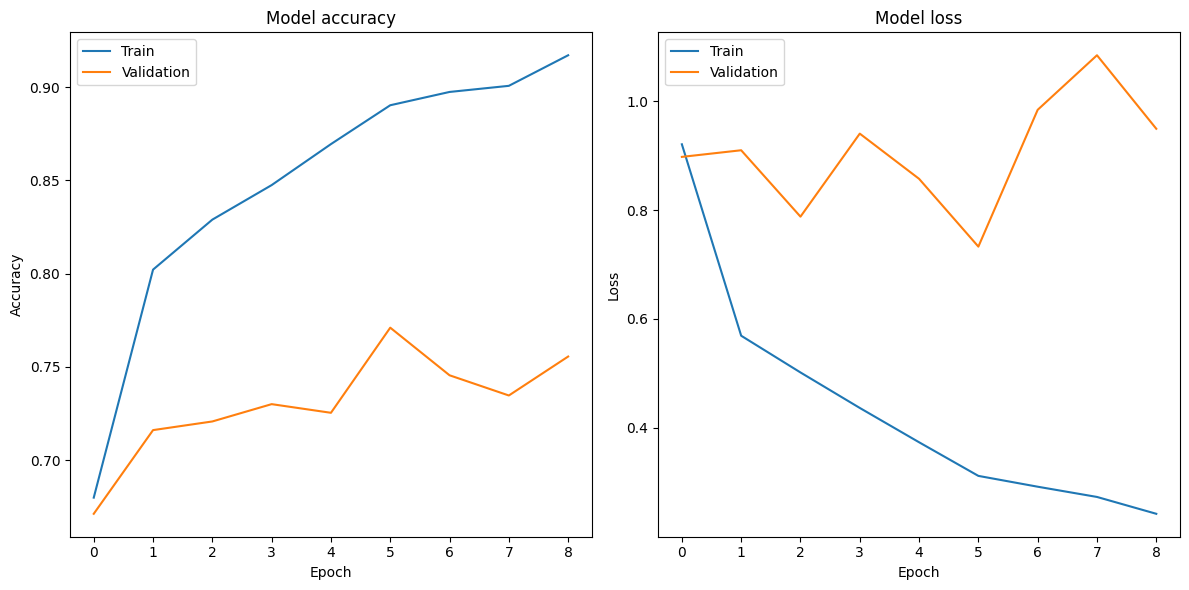

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [34]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [35]:
import tensorflowjs as tfjs
import tensorflow as tf

# Save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Convert and save the model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model for TensorFlow Serving
# Create a directory for the saved model
import os
model_version = 1
export_path = os.path.join('serving_model', str(model_version))
print('export_path = {}\n'.format(export_path))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)
print('\nSaved model:')
!ls -l {export_path}


failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmpxb51ky1n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_186')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136769675964688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675960656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675967568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675965264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675967184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675961232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675963728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675958352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136769675960080: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [36]:
# prompt: gunakan salah satu model yang disimpan untuk menguji suatu gambar dari luar

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('serving_model/1') # Replace with the actual path

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")


ValueError: File format not supported: filepath=serving_model/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(serving_model/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [37]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model using tf.saved_model.load
model = tf.saved_model.load('serving_model/1')

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/image_to_test.jpg'